# Battery bidding functions

## To do

This code represents a battery which is participating in a real-time market (every 5min). At the beginning of each market interval, the battery places a buy bid (maximum price at which it is willing to buy) and a supply bid (minimum price at which it is willing to sell). Then, the market reveals the true real-time price. If the price is lower than the buy bid, the battery charges. If the price is higher than the sell price, the battery discharges. 

The objective of this task is to write bidding functions which maximize the battery's profit or some other objective.

Please go through the following steps:

Week 3:
* Go through the code and try to understand each part. Currently, a very simple bidding function (simple_bid()) is implemented. Run the code from the top.
* Write the function calculate_battery_profit() which calculates the profits from operating the battery.
* Write the function visualize_battery_dispatch() which visualizes when the battery dispatches as well as the market price.
* Test your code for a week-long simulation period.

Week 4:
* Think of other evaluations and visualizations of the battery behavior and implement them.
* Make a strategy of how to implement one of the following new bidding functions and discuss them with Marie-Louise and Lynne:
    - bid_costminizing()
    - bid_optimal_autarky()
    - bid_optimal_RL()
* Implement your bidding function and test and visualize it.

Week 5:
* Repeat the same for the other bidding functions.

Once you have finalized your code, we will implement your code in GridLAB-D and test them in a more complex distribution system. For the next steps, have a look at the GoogleDoc with your workplan-

When you have questions, don't hesitate to contact Anna, Lynne, or Marie-Louise!

## Modules

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 50)
import cvxpy
from matplotlib.dates import drange
import random
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Define bidding functions

In [2]:
#df_battery_state
# change order possibly?

In [3]:
def bid_simple(dt_sim_time,df_battery_state,df_WS,df_prices):
    #derive quantity and price bid of battery
    prec = 3 # rounding
    
    # Price bid
    # mean_p is the mean price starting from dt_sim_time to 4 hours in the future
    mean_p = df_WS.loc[dt_sim_time:(dt_sim_time+datetime.timedelta(hours = 4))]['DA'].mean()
    df_battery_state['p_sell'] = mean_p / df_battery_state['efficiency']
    df_battery_state['p_buy'] = mean_p * df_battery_state['efficiency']
    
    # Quantity depends on SOC and u
    safety_fac = 0.99
    df_battery_state['residual_s'] = round((3600./interval)*(df_battery_state['SOC_t'] - df_battery_state['SOC_min']),prec) #Recalculate to kW
    #print(df_battery_state[['residual_s','u_max']])
    #comparing what the battery can discharge in power and in energy, choose the one that is more restrictive
    df_battery_state['q_sell'] = df_battery_state[['residual_s','u_max']].min(axis=1) #in kW / only if fully dischargeable
    #comment out and check later 
    df_battery_state['q_sell'].loc[df_battery_state['q_sell'] < 0.1] = 0.0
    #filtering out what is less than 0.1, because of python
    #comparing what the battery can charge in power and in energy, choose the one that is more restrictive
    #do not want to discharge until it fully discharged
    #double check minimum soc
    #min state of charge is 1 kwh
    df_battery_state['residual_b'] = round((3600./interval)*(safety_fac*df_battery_state['SOC_max'] - df_battery_state['SOC_t']),prec) #Recalculate to kW
    #print(df_battery_state[['residual_b','u_max']])
    df_battery_state['q_buy'] = df_battery_state[['residual_b','u_max']].min(axis=1) #in kW
    df_battery_state['q_buy'].loc[df_battery_state['q_buy'] < 0.1] = 0.0
    
    #print(df_battery_state)
    return df_battery_state

In [4]:
def bid_costminizing(df_battery_state): # Adjust input
    time_horizon = 4*3600/interval # optimization horizon
    # Determine the optimal dispatch schedule of the battery over the optimization horizon,
    #    given day-ahead (DA) prices from df_WS. Use the package cvxpy.
    # Determine profits from (t+1) on if battery had charged/discharged/not done anything in t
    # The profit/cost from charging/doing nothing/discharging in t and the future value in (t+1) 
    #    if the value of the action charging/doing nothing/discharging in t
    #    --> This principle is called the Bellman principle
    # Which prices make the battery operator equivalent between:
    # - charging or doing nothing? --> This is the maximum price at which the battery operator
    #   is willing to buy
    # - discharging or doing nothing? --> This is the minimum price at which the battery operator
    #   is willing to sell
    return df_battery_state

In [5]:
def bid_optimal_autarky(df_battery_state):
    # Design and implement a bidding strategy of an agent who values a high state-of-charge
    # but is willing to go below the minimum SOC if the agent could achieve substantial profits
    return df_battery_state

In [6]:
def bid_optimal_RL(df_battery_state):
    # Maximize battery profit using Reinforcement Learning
    # Use the following RL algorithm: https://dl.acm.org/doi/10.1145/3208903.3208907 (Section 4)
    return df_battery_state

## Evaluation functions

In [58]:
df_prices

,clearing_price,clearing_quantity,unresponsive_loads
2016-07-01 00:00:00,19.48,0.0,0.0
2016-07-01 00:05:00,19.48,0.0,0.0
2016-07-01 00:10:00,19.48,0.0,0.0
2016-07-01 00:15:00,19.92,0.0,0.0
2016-07-01 00:20:00,19.92,0.0,0.0
...,...,...,...
2016-07-07 00:40:00,18.14,0.4,0.0
2016-07-07 00:45:00,17.73,0.0,0.0
2016-07-07 00:50:00,17.73,0.0,0.0
2016-07-07 00:55:00,17.73,0.0,0.0


In [7]:
def calculate_battery_profit(df_awarded_bids, df_prices):
    # Calculate profit from selling and buying energy
    # prices are in USD/MWh and u_max = 1 kWh
    # Multiply by 1/12 because market intervals are 5 minutes
    
    profit=0
    expenses=0
    income=0
    for index, row in df_awarded_bids.iterrows():
        if row['S_D']=='S':
            income = income + (df_prices.loc[row['timestamp'], 'clearing_price'])*(1/12)*(1/1000)
        elif row['S_D']=='D':
            expenses = expenses + (df_prices.loc[row['timestamp'], 'clearing_price'])*(1/12)*(1/1000)
    profit=income-expenses
    return profit

In [8]:
# this one scales better but is less readable 
def calculate_battery_profit(awarded_bids, prices):
    '''
    This function calculates ... 
    
    Inputs:
    - awarded_bids: a pd dataframe containing ...
    - prices: a pd dataframe containing ...
    
    Output: 
    - profit: ... 
    
    '''
    income_by_time = prices.loc[awarded_bids[awarded_bids['S_D']=='S']['timestamp'], 
                               ['clearing_price', 'clearing_quantity']].prod(axis=1)
    income = sum(income_by_time) / (12 * 1000)
    expense_by_time = prices.loc[awarded_bids[awarded_bids['S_D']=='D']['timestamp'], 
                               ['clearing_price', 'clearing_quantity']].prod(axis=1)
    expense = sum(expense_by_time) / (12 * 1000)
    profit = income - expense
    return profit

In [9]:
def visualize_battery_dispatch2(ys):
    fig, ax = plt.subplots()

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(market_intervals, ys)
    plt.show()

In [10]:
def visualize_battery_dispatch3(ys2):
    ys2 = np.array(ys2)
    ys2[:, 0] = (ys2[:, -1] == 1) * ys2[:, 0]
    ys2[:, 1] = (ys2[:, -1] == -1) * ys2[:, 1]
    
    fig, ax = plt.subplots()

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(market_intervals, np.array(ys2)[:, 0], label='q_buy')
    ax.plot(market_intervals, np.array(ys2)[:, 1], label='q_sell')
    plt.legend()

## Other functions

In [11]:
# Update battery function: updates the batteries' state of charge
# (Same as in market_simulation code)
def update_battery(df_battery_state):
    #-1: discharging, 0 no activity, 1 charging
    #history is saved by battery recorder (P_out)
    df_battery_state['active_t-1'] = df_battery_state['active_t']
    df_battery_state['active_t'] = 0 # random.choice([-1, 0, 1])
    df_battery_state['SOC_t'] = df_battery_state['SOC_t']*df_battery_state['efficiency']
    # fixed from before
    df_battery_state['SOC_t'].loc[df_battery_state['active_t-1'] == -1] -= interval/3600*df_battery_state['q_sell'].loc[df_battery_state['active_t-1'] == -1]
    df_battery_state['SOC_t'].loc[df_battery_state['active_t-1'] == 1] += interval/3600*df_battery_state['q_buy'].loc[df_battery_state['active_t-1'] == 1]
    return df_battery_state

In [12]:
# Write bids to result tables
def submit_bids_battery(dt_sim_time,retail,df_bids,df_supply_bids,df_buy_bids):
    for ind in df_bids.index:
        if df_bids['q_sell'].loc[ind] > 0.0:
            #retail.sell(df_bids['q_sell'].loc[ind],df_bids['p_sell'].loc[ind],gen_name=ind)
            df_supply_bids = df_supply_bids.append(pd.DataFrame(columns=df_supply_bids.columns,data=[[dt_sim_time,ind,float(df_bids['p_sell'].loc[ind]),float(df_bids['q_sell'].loc[ind])]]),ignore_index=True)
        if df_bids['q_buy'].loc[ind] > 0.0:
            #retail.buy(df_bids['q_buy'].loc[ind],df_bids['p_buy'].loc[ind],active=df_bids['active_t-1'].loc[ind],appliance_name=ind)
            df_buy_bids = df_buy_bids.append(pd.DataFrame(columns=df_buy_bids.columns,data=[[dt_sim_time,ind,float(df_bids['p_buy'].loc[ind]),float(df_bids['q_buy'].loc[ind])]]),ignore_index=True)
    df_bids['active_t-1'] = 0
    return retail,df_supply_bids,df_buy_bids

`(df_bids_battery['p_buy'] >= Pd) & (df_bids_battery['SOC_t'] >= df_bids_battery['SOC_max'])`

- Return False (0) only when we can buy
- Return True (1) when either of these conditions are violated

In [13]:
# Determines if battery should be dispatched and how
def set_battery_by_price(dt_sim_time,df_bids_battery,Pd, df_awarded_bids):
    #Determine activity
    df_bids_battery.at[:,'active_t'] = 0
    df_bids_battery.at[(df_bids_battery['p_buy'] >= Pd) & (df_bids_battery['SOC_t'] < df_bids_battery['SOC_max']),'active_t'] = 1
    df_bids_battery.at[(df_bids_battery['p_sell'] <= Pd) & (df_bids_battery['SOC_t'] > 0.0),'active_t'] = -1
    #print(df_bids_battery)
    # Save to awarded bids
    for battery in df_bids_battery.index:
        batt_number = battery
        SOC = df_bids_battery['SOC_t'].loc[battery] #this is SOC at the beginning of the period t
        active = df_bids_battery['active_t'].loc[battery] #this is activity in t
        if active == 1:
            q_bid = df_bids_battery['q_buy'].loc[battery]
            p_bid = df_bids_battery['p_buy'].loc[battery]
            df_awarded_bids = df_awarded_bids.append(pd.DataFrame(columns=df_awarded_bids.columns,data=[[dt_sim_time,battery,float(p_bid),float(q_bid),'D']]),ignore_index=True)
        elif active == -1:
            q_bid = df_bids_battery['q_sell'].loc[battery]
            p_bid = df_bids_battery['p_sell'].loc[battery]
            df_awarded_bids = df_awarded_bids.append(pd.DataFrame(columns=df_awarded_bids.columns,data=[[dt_sim_time,battery,float(p_bid),float(q_bid),'S']]),ignore_index=True)
    return df_bids_battery,df_awarded_bids

## Initialize objects and data

In [14]:
# Initialize battery 1
cols_battery = ['battery_name','house_name','SOC_min','SOC_max','i_max','u_max','efficiency','SOC_t','active_t-1','active_t','threshold_sell','threshold_buy','q_sell','p_sell','q_buy','p_buy']
#values = [['batt_1','house_1',1.,5.,1.,1.,0.99,2.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0]]
values = [['batt_1','house_1',1.,5.,1.,1.,1,2.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0]]
#set efficiency factor to 1 and rerun market 
df_battery_state = pd.DataFrame(columns=cols_battery,data=values)

In [15]:
# WS costs
df_WS = pd.read_csv('glm_generation_Austin/Ercot_LZ_SOUTH.csv',parse_dates=True,index_col=[0]) # For year 2016
df_WS.head()

,DA,RT
2016-01-01 00:00:00,18.22,15.48
2016-01-01 00:05:00,18.22,15.48
2016-01-01 00:10:00,18.22,15.48
2016-01-01 00:15:00,18.22,15.33
2016-01-01 00:20:00,18.22,15.33


In [16]:
# Initialize market parameters
start = datetime.datetime( 2016, 7, 1)
end = datetime.datetime( 2016, 7, 7, 1, 0)
interval = 300 # interval of market operation
market_intervals = pd.date_range(start,end,freq=str(int(interval/60))+'min')
market_intervals #the first hour in 5 minute increments

DatetimeIndex(['2016-07-01 00:00:00', '2016-07-01 00:05:00',
               '2016-07-01 00:10:00', '2016-07-01 00:15:00',
               '2016-07-01 00:20:00', '2016-07-01 00:25:00',
               '2016-07-01 00:30:00', '2016-07-01 00:35:00',
               '2016-07-01 00:40:00', '2016-07-01 00:45:00',
               ...
               '2016-07-07 00:15:00', '2016-07-07 00:20:00',
               '2016-07-07 00:25:00', '2016-07-07 00:30:00',
               '2016-07-07 00:35:00', '2016-07-07 00:40:00',
               '2016-07-07 00:45:00', '2016-07-07 00:50:00',
               '2016-07-07 00:55:00', '2016-07-07 01:00:00'],
              dtype='datetime64[ns]', length=1741, freq='5T')

## Run market

In [59]:
# Set up df to save results
# Setting up empty data frames
#Test cases - unit test
#to make this a function, pass in these dataframes + market intervals + 
df_prices = pd.DataFrame(columns=['clearing_price','clearing_quantity','unresponsive_loads'])
df_buy_bids = pd.DataFrame(columns=['timestamp','appliance_name','bid_price','bid_quantity'])
df_supply_bids = pd.DataFrame(columns=['timestamp','appliance_name','bid_price','bid_quantity'])
df_awarded_bids = pd.DataFrame(columns=['timestamp','appliance_name','bid_price','bid_quantity','S_D'])
df_store = pd.DataFrame(columns=['timestamp', 'RT', 'SOC_t', 'q_buy', 'q_sell', 'active_t'])


def run_market(df_prices, df_buy_bids, df_supply_bids, df_awarded_bids, df_store, market_intervals, df_battery_state, df_WS):

    for dt_sim_time in market_intervals:
        #print(dt_sim_time)
        # Update physical state of battery
        df_battery_state = update_battery(df_battery_state)
        #records current state of charge

        # Setup market
        retail = None # this is a placeholder

        # Bid : THIS IS WHERE YOU SHOULD IMPLEMENT AND TEST BIDDING FUNCTIONS
        df_battery_state = bid_simple(dt_sim_time,df_battery_state,df_WS,df_prices)
        #bid_costminizing(dt_sim_time,df_battery_state,df_WS,df_prices)
        #bid_optimal_autarky(dt_sim_time,df_battery_state,df_WS,df_prices)
        retail,df_supply_bids,df_buy_bids = submit_bids_battery(dt_sim_time,retail,df_battery_state,df_supply_bids,df_buy_bids)
        # Clear market and save price
        Pd = df_WS['RT'].loc[dt_sim_time:dt_sim_time].iloc[-1]
        #-1 means we use the last price
        #Pd is clearing price
        Qd = max(df_battery_state['q_sell'].loc[df_battery_state['p_sell'] <= Pd].sum(),df_battery_state['q_buy'].loc[df_battery_state['p_buy'] >= Pd].sum())
        #Qd is clearing quantity
        unresp_load = 0.0
        df_temp = pd.DataFrame(index=[dt_sim_time],columns=['clearing_price','clearing_quantity','unresponsive_loads'],data=[[Pd,Qd,unresp_load]])
        df_prices = df_prices.append(df_temp)
        # Dispatch battery
        # Calls the function in order to append and fill the empty data frames
        df_bids_battery, df_awarded_bids = set_battery_by_price(dt_sim_time,df_battery_state, Pd, df_awarded_bids)

        df_temp2 = pd.DataFrame(columns=['timestamp', 'RT', 'SOC_t', 'q_buy', 'q_sell', 'active_t'], data=[[dt_sim_time, Pd, df_battery_state['SOC_t'].values[0], *df_battery_state[['q_buy', 'q_sell', 'active_t']].values[0]]])
        df_store = df_store.append(df_temp2) 
        #set_battery_by_price
    df_store = df_store.set_index('timestamp')

    #check df_store
    df_store['q_buy'] = (df_store.active_t==1)*df_store.q_buy
    df_store['q_sell'] = (df_store.active_t==-1)*df_store.q_sell
    df_store['q_transaction'] =  df_store['q_buy'] - df_store['q_sell']
    df_store['q_transaction'] = df_store['q_transaction']*(-1)
    
    return df_store, df_prices, df_bids_battery, df_awarded_bids
    
df_store, df_prices, df_bids_battery, df_awarded_bids = run_market(df_prices, df_buy_bids, df_supply_bids, df_awarded_bids, df_store, market_intervals, df_battery_state, df_WS)


In [60]:
df_awarded_bids

,timestamp,appliance_name,bid_price,bid_quantity,S_D
0,2016-07-01 00:00:00,0,17.448776,0.0,S
1,2016-07-01 00:05:00,0,17.379184,0.0,S
2,2016-07-01 00:10:00,0,17.309592,0.0,S
3,2016-07-01 00:15:00,0,17.240000,0.0,S
4,2016-07-01 00:20:00,0,17.170408,0.0,S
...,...,...,...,...,...
1736,2016-07-07 00:40:00,0,15.539000,0.4,S
1737,2016-07-07 00:45:00,0,15.455800,0.0,S
1738,2016-07-07 00:50:00,0,15.372600,0.0,S
1739,2016-07-07 00:55:00,0,15.289400,0.0,S


In [22]:
len(df_store.active_t==1)
len(df_store)
#check later is equal length

0

## Visualize market results

## Calculate battery profit

In [37]:
df_store

,RT,SOC_t,q_buy,q_sell,active_t,q_transaction
timestamp,,,,,,
2016-07-01 00:00:00,19.48,1.000000,0.0,0.0,-1.0,-0.0
2016-07-01 00:05:00,19.48,1.000000,0.0,0.0,-1.0,-0.0
2016-07-01 00:10:00,19.48,1.000000,0.0,0.0,-1.0,-0.0
2016-07-01 00:15:00,19.92,1.000000,0.0,0.0,-1.0,-0.0
2016-07-01 00:20:00,19.92,1.000000,0.0,0.0,-1.0,-0.0
...,...,...,...,...,...,...
2016-07-07 00:40:00,18.14,1.033333,0.0,0.4,-1.0,0.4
2016-07-07 00:45:00,17.73,1.000000,0.0,0.0,-1.0,-0.0
2016-07-07 00:50:00,17.73,1.000000,0.0,0.0,-1.0,-0.0


In [38]:
df_WS

,DA,RT
2016-01-01 00:00:00,18.22,15.48
2016-01-01 00:05:00,18.22,15.48
2016-01-01 00:10:00,18.22,15.48
2016-01-01 00:15:00,18.22,15.33
2016-01-01 00:20:00,18.22,15.33
...,...,...
2016-12-31 23:35:00,24.97,22.71
2016-12-31 23:40:00,24.97,22.71
2016-12-31 23:45:00,24.97,22.81
2016-12-31 23:50:00,24.97,22.81


In [61]:
# In USD
calculate_battery_profit(df_awarded_bids, df_prices)


0.2357446666666665

In [55]:
df_prices

,clearing_price,clearing_quantity,unresponsive_loads
2016-07-01 00:00:00,19.48,0.0,0.0
2016-07-01 00:05:00,19.48,0.0,0.0
2016-07-01 00:10:00,19.48,0.0,0.0
2016-07-01 00:15:00,19.92,0.0,0.0
2016-07-01 00:20:00,19.92,0.0,0.0
...,...,...,...
2016-07-07 00:40:00,18.14,0.4,0.0
2016-07-07 00:45:00,17.73,0.0,0.0
2016-07-07 00:50:00,17.73,0.0,0.0
2016-07-07 00:55:00,17.73,0.0,0.0


In [44]:
start, end

(datetime.datetime(2016, 7, 1, 0, 0), datetime.datetime(2016, 7, 7, 1, 0))

In [39]:
df_store.RT

timestamp
2016-07-01 00:00:00    19.48
2016-07-01 00:05:00    19.48
2016-07-01 00:10:00    19.48
2016-07-01 00:15:00    19.92
2016-07-01 00:20:00    19.92
                       ...  
2016-07-07 00:40:00    18.14
2016-07-07 00:45:00    17.73
2016-07-07 00:50:00    17.73
2016-07-07 00:55:00    17.73
2016-07-07 01:00:00    18.17
Name: RT, Length: 1741, dtype: float64

In [43]:
df_store.SOC_t

timestamp
2016-07-01 00:00:00    1.000000
2016-07-01 00:05:00    1.000000
2016-07-01 00:10:00    1.000000
2016-07-01 00:15:00    1.000000
2016-07-01 00:20:00    1.000000
                         ...   
2016-07-07 00:40:00    1.033333
2016-07-07 00:45:00    1.000000
2016-07-07 00:50:00    1.000000
2016-07-07 00:55:00    1.000000
2016-07-07 01:00:00    1.000000
Name: SOC_t, Length: 1741, dtype: float64

In [42]:
df_store.q_transaction

timestamp
2016-07-01 00:00:00   -0.0
2016-07-01 00:05:00   -0.0
2016-07-01 00:10:00   -0.0
2016-07-01 00:15:00   -0.0
2016-07-01 00:20:00   -0.0
                      ... 
2016-07-07 00:40:00    0.4
2016-07-07 00:45:00   -0.0
2016-07-07 00:50:00   -0.0
2016-07-07 00:55:00   -0.0
2016-07-07 01:00:00   -0.0
Name: q_transaction, Length: 1741, dtype: float64

In [40]:
def visualize_battery_dispatch(data):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    plot1 = ax.plot(data.RT, color='xkcd:sky blue', label='RT')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
    ax.set_xlim(xmin=start,xmax=end+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_ylim(0.0,150)
#     ax2 = fig.add_subplot(211)

    ax2 = ax.twinx()
    plot2 = ax2.plot(data.SOC_t, color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
#     ax3 = fig.add_subplot(311)
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    plot3 = ax3.plot(data.q_transaction, color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)

#     plot3 = ax3.plot(np.array(ys2)[:, 0], label='q_buy', color='red')
#     plot4 = ax3.plot(np.array(ys2)[:, 1], label='q_sell', color='green')
    
    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))
#     ppt.savefig(directory+'/week_'+str(start)+'.pdf', bbox_inches='tight')
#     ppt.savefig(directory+'/week_'+str(start)+'.png', bbox_inches='tight')


    #     locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
#     formatter = mdates.ConciseDateFormatter(locator)
#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(formatter)
#     x=df.index
#     y=df.RT
#     ax.plot(x, y)
#     plt.show()

        #x = [datetime.datetime.strptime(elem, '%Y-%b-%d %H:%M:%S') for elem in x]
#     return

<ipython-input-40-025953516003>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


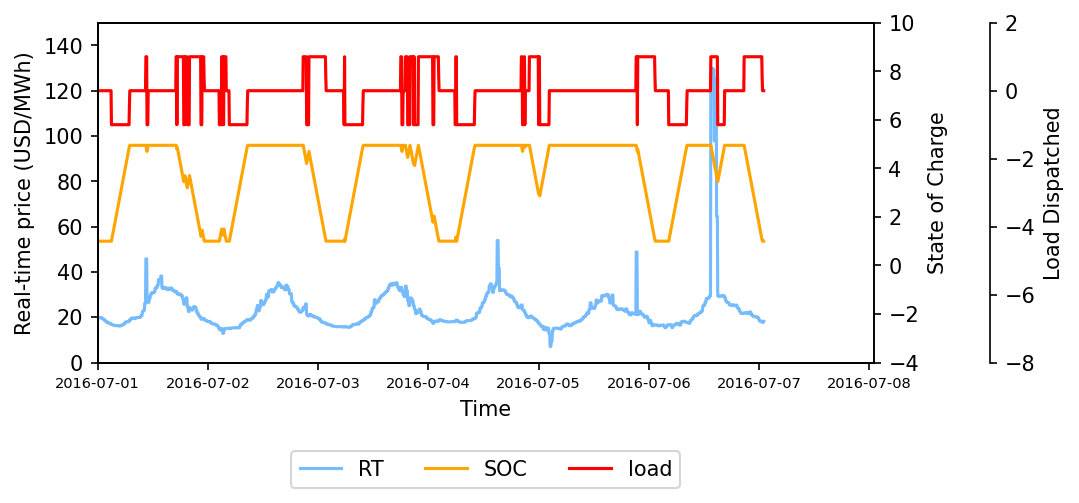

In [41]:
visualize_battery_dispatch(df_store)
# rename functions
# add units for load dispatched
# change up the overlapping graphs
#test the bid simple- test a different average